<a href="https://colab.research.google.com/github/leonsuarez24/Notebooks/blob/main/Dataset_Contensation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
!pip install torchinfo
from torchinfo import summary
import copy
import torch.optim as optim

# Parameters

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
dataset = 'MNIST'
ipc = 10 # image(s) per class
num_eval = 20 # the number of evaluating randomly initialized models
epoch_eval_train = 300 # epochs to train a model with synthetic data
Iteration = 1000 # training iterations
lr_img = 0.1 # learning rate for updating synthetic images
lr_net = 0.01 # learning rate for updating network parameters
batch_real = 256 # batch size for real data
batch_train = 256 # batch size for training networks

# Utils

In [3]:
class TensorDataset(Dataset):
    def __init__(self, images, labels): # images: n x c x h x w tensor
        self.images = images.detach().float()
        self.labels = labels.detach()

    def __getitem__(self, index):
        return self.images[index], self.labels[index]

    def __len__(self):
        return self.images.shape[0]

In [4]:
def get_dataset(dataset, data_path='./data'):
    if dataset == 'MNIST':
        channel = 1
        im_size = (28, 28)
        num_classes = 10
        mean = [0.1307]
        std = [0.3081]
        transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=mean, std=std)])
        dst_train = datasets.MNIST(data_path, train=True, download=True, transform=transform) # no augmentation
        dst_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)
        class_names = [str(c) for c in range(num_classes)]

    elif dataset == 'FashionMNIST':
        channel = 1
        im_size = (28, 28)
        num_classes = 10
        mean = [0.2861]
        std = [0.3530]
        transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=mean, std=std)])
        dst_train = datasets.FashionMNIST(data_path, train=True, download=True, transform=transform) # no augmentation
        dst_test = datasets.FashionMNIST(data_path, train=False, download=True, transform=transform)
        class_names = dst_train.classes

    elif dataset == 'SVHN':
        channel = 3
        im_size = (32, 32)
        num_classes = 10
        mean = [0.4377, 0.4438, 0.4728]
        std = [0.1980, 0.2010, 0.1970]
        transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=mean, std=std)])
        dst_train = datasets.SVHN(data_path, split='train', download=True, transform=transform)  # no augmentation
        dst_test = datasets.SVHN(data_path, split='test', download=True, transform=transform)
        class_names = [str(c) for c in range(num_classes)]

    elif dataset == 'CIFAR10':
        channel = 3
        im_size = (32, 32)
        num_classes = 10
        mean = [0.4914, 0.4822, 0.4465]
        std = [0.2023, 0.1994, 0.2010]
        transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=mean, std=std)])
        dst_train = datasets.CIFAR10(data_path, train=True, download=True, transform=transform) # no augmentation
        dst_test = datasets.CIFAR10(data_path, train=False, download=True, transform=transform)
        class_names = dst_train.classes

    else:
        exit('unknown dataset: %s'%dataset)

    testloader = torch.utils.data.DataLoader(dst_test, batch_size=256, shuffle=False, num_workers=2)
    return channel, im_size, num_classes, class_names, mean, std, dst_train, dst_test, testloader

In [5]:
def get_loops(ipc):
    # Get the two hyper-parameters of outer-loop and inner-loop.
    # The following values are empirically good.
    if ipc == 1:
        outer_loop, inner_loop = 1, 1
    elif ipc == 10:
        outer_loop, inner_loop = 10, 50
    elif ipc == 20:
        outer_loop, inner_loop = 20, 25
    elif ipc == 30:
        outer_loop, inner_loop = 30, 20
    elif ipc == 40:
        outer_loop, inner_loop = 40, 15
    elif ipc == 50:
        outer_loop, inner_loop = 50, 10
    else:
        outer_loop, inner_loop = 0, 0
        exit('DC error: loop hyper-parameters are not defined for %d ipc'%ipc)
    return outer_loop, inner_loop

In [6]:
def get_images(c, n): # get random n images from class c
    idx_shuffle = np.random.permutation(indices_class[c])[:n]
    return images_all[idx_shuffle]

In [7]:
def epoch(mode, dataloader, net, optimizer, criterion, device):
    loss_avg, acc_avg, num_exp = 0, 0, 0
    net = net.to(device)
    criterion = criterion.to(device)

    if mode == 'train':
        net.train()
    else:
        net.eval()

    for i_batch, datum in enumerate(dataloader):
        img = datum[0].float().to(device)
        lab = datum[1].long().to(device)
        n_b = lab.shape[0]

        output = net(img)
        loss = criterion(output, lab)
        acc = np.sum(np.equal(np.argmax(output.cpu().data.numpy(), axis=-1), lab.cpu().data.numpy()))

        loss_avg += loss.item()*n_b
        acc_avg += acc
        num_exp += n_b

        if mode == 'train':
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    loss_avg /= num_exp
    acc_avg /= num_exp

    return loss_avg, acc_avg

In [8]:
def evaluate_synset(net, images_train, labels_train, testloader, learningrate, batchsize_train, device, Epoch = 600):
    net = net.to(device)
    images_train = images_train.to(device)
    labels_train = labels_train.to(device)
    lr = float(learningrate)
    lr_schedule = [Epoch//2+1]
    optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=0.0005)
    criterion = nn.CrossEntropyLoss().to(device)

    dst_train = TensorDataset(images_train, labels_train)
    trainloader = torch.utils.data.DataLoader(dst_train, batch_size=batchsize_train, shuffle=True, num_workers=0)

    for ep in range(Epoch+1):
        loss_train, acc_train = epoch('train', trainloader, net, optimizer, criterion, device)
        if ep in lr_schedule:
            lr *= 0.1
            optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=0.0005)

    loss_test, acc_test = epoch('test', testloader, net, optimizer, criterion, device)
    print('Evaluate: epoch = %04d, train loss = %.6f, train acc = %.4f, test acc = %.4f' % (Epoch, loss_train, acc_train, acc_test))

    return net, acc_train, acc_test

# Match loss

In [9]:
def distance_wb(gwr, gws):
    shape = gwr.shape
    if len(shape) == 4: # conv, out*in*h*w
        gwr = gwr.reshape(shape[0], shape[1] * shape[2] * shape[3])
        gws = gws.reshape(shape[0], shape[1] * shape[2] * shape[3])
    elif len(shape) == 3:  # layernorm, C*h*w
        gwr = gwr.reshape(shape[0], shape[1] * shape[2])
        gws = gws.reshape(shape[0], shape[1] * shape[2])
    elif len(shape) == 2: # linear, out*in
        tmp = 'do nothing'
    elif len(shape) == 1: # batchnorm/instancenorm, C; groupnorm x, bias
        gwr = gwr.reshape(1, shape[0])
        gws = gws.reshape(1, shape[0])
        return 0

    dis_weight = torch.sum(1 - torch.sum(gwr * gws, dim=-1) / (torch.norm(gwr, dim=-1) * torch.norm(gws, dim=-1) + 0.000001))
    dis = dis_weight
    return dis

def match_loss(gw_syn, gw_real):
    dis = torch.tensor(0.0).to(device)
    for ig in range(len(gw_real)):
        dis += distance_wb(gw_real[ig], gw_syn[ig])
    return dis

# Network

In [10]:
class LeNet(nn.Module):
    def __init__(self, channel, num_classes):
        super(LeNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(channel, 6, kernel_size=5, padding=2 if channel==1 else 0),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc_1 = nn.Linear(16 * 5 * 5, 120)
        self.fc_2 = nn.Linear(120, 84)
        self.fc_3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc_1(x))
        x = F.relu(self.fc_2(x))
        x = self.fc_3(x)
        return x

In [11]:
network = LeNet(1,10).to(device)
summary(network, (32,1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
LeNet                                    [32, 10]                  --
├─Sequential: 1-1                        [32, 16, 5, 5]            --
│    └─Conv2d: 2-1                       [32, 6, 28, 28]           156
│    └─ReLU: 2-2                         [32, 6, 28, 28]           --
│    └─MaxPool2d: 2-3                    [32, 6, 14, 14]           --
│    └─Conv2d: 2-4                       [32, 16, 10, 10]          2,416
│    └─ReLU: 2-5                         [32, 16, 10, 10]          --
│    └─MaxPool2d: 2-6                    [32, 16, 5, 5]            --
├─Linear: 1-2                            [32, 120]                 48,120
├─Linear: 1-3                            [32, 84]                  10,164
├─Linear: 1-4                            [32, 10]                  850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
Total mult-adds (M): 13.54
Input size (MB): 0.10
Forward/backward pass s

#Dataset

In [12]:
outer_loop, inner_loop = get_loops(ipc) # Get the two hyper-parameters of outer-loop and inner-loop

In [13]:
channel, im_size, num_classes, class_names, mean, std, dst_train, dst_test, testloader = get_dataset(dataset)

100%|██████████| 9912422/9912422 [00:00<00:00, 170815096.57it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 97219657.96it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 47771578.34it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 19539003.86it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [14]:
images_all = []
labels_all = []
indices_class = [[] for c in range(num_classes)]

images_all = [torch.unsqueeze(dst_train[i][0], dim=0) for i in range(len(dst_train))] # Save the images (1,1,28,28)
labels_all = [dst_train[i][1] for i in range(len(dst_train))] # Save the labels

In [15]:
for i, lab in enumerate(labels_all): # Save the index of each class labels
    indices_class[lab].append(i)
images_all = torch.cat(images_all, dim=0).to(device) # Cat images along the batch dimension
labels_all = torch.tensor(labels_all, dtype=torch.long, device=device) # Make the labels a tensor

for c in range(num_classes):
    print('class c = %d: %d real images'%(c, len(indices_class[c]))) # Prints how many labels are for each class

class c = 0: 5923 real images
class c = 1: 6742 real images
class c = 2: 5958 real images
class c = 3: 6131 real images
class c = 4: 5842 real images
class c = 5: 5421 real images
class c = 6: 5918 real images
class c = 7: 6265 real images
class c = 8: 5851 real images
class c = 9: 5949 real images


# Initialize syntethic images as noise

In [16]:
# Initialize syntethic data as noise, ipc = images per class
image_syn = torch.randn(size=(num_classes*ipc, channel, im_size[0], im_size[1]), dtype=torch.float, requires_grad=True, device=device)
label_syn = torch.tensor([np.ones(ipc)*i for i in range(num_classes)], dtype=torch.long, requires_grad=False, device=device).view(-1) # [0,0,0, 1,1,1, ..., 9,9,9]

<ipython-input-16-86687fc7559a>:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  label_syn = torch.tensor([np.ones(ipc)*i for i in range(num_classes)], dtype=torch.long, requires_grad=False, device=device).view(-1) # [0,0,0, 1,1,1, ..., 9,9,9]


## Training

In [17]:
optimizer_img = torch.optim.SGD([image_syn, ], lr=lr_img, momentum=0.5) # optimizer_img for synthetic data
optimizer_img.zero_grad()
criterion = nn.CrossEntropyLoss().to(device) # Loss function

In [19]:
for it in range(Iteration+1):
    ''' Train synthetic data '''
    net = LeNet(channel=channel, num_classes=num_classes).to(device)
    net.train()
    net_parameters = list(net.parameters())
    optimizer_net = torch.optim.SGD(net.parameters(), lr=lr_net, momentum=0.5)  # optimizer_img for synthetic data
    optimizer_net.zero_grad()
    loss_avg = 0

    for ol in range(outer_loop):

        ''' update synthetic data '''
        loss = torch.tensor(0.0).to(device)
        for c in range(num_classes):
            img_real = get_images(c, batch_real)
            lab_real = torch.ones((img_real.shape[0],), device=device, dtype=torch.long) * c
            output_real = net(img_real)
            loss_real = criterion(output_real, lab_real)
            gw_real = torch.autograd.grad(loss_real, net_parameters)
            gw_real = list((_.detach().clone() for _ in gw_real))

            img_syn = image_syn[c*ipc:(c+1)*ipc].reshape((ipc, channel, im_size[0], im_size[1]))
            lab_syn = torch.ones((ipc,), device=device, dtype=torch.long) * c
            output_syn = net(img_syn)
            loss_syn = criterion(output_syn, lab_syn)
            gw_syn = torch.autograd.grad(loss_syn, net_parameters, create_graph=True)

            loss += match_loss(gw_syn, gw_real)

        optimizer_img.zero_grad()
        loss.backward()
        optimizer_img.step()
        loss_avg += loss.item()

        if ol == outer_loop - 1:
            break


        ''' update network '''
        image_syn_train, label_syn_train = copy.deepcopy(image_syn.detach()), copy.deepcopy(label_syn.detach())  # avoid any unaware modification
        dst_syn_train = TensorDataset(image_syn_train, label_syn_train)
        trainloader = torch.utils.data.DataLoader(dst_syn_train, batch_size=batch_train, shuffle=True, num_workers=0)
        for il in range(inner_loop):
            epoch('train', trainloader, net, optimizer_net, criterion, device)

In [20]:
accs = []
for it_eval in range(num_eval):
    net_eval = LeNet(channel=channel, num_classes=num_classes).to(device) # get a random model (initialize a network)
    image_syn_eval, label_syn_eval = copy.deepcopy(image_syn.detach()), copy.deepcopy(label_syn.detach()) # avoid any unaware modification
    # Trains a model in syntethic data, epoch_eval_train = 1000
    _, acc_train, acc_test = evaluate_synset(net_eval, image_syn_eval, label_syn_eval, testloader, lr_net, batch_train, device, epoch_eval_train)
    accs.append(acc_test)


Evaluate: epoch = 0300, train loss = 0.018169, train acc = 1.0000, test acc = 0.8691
Evaluate: epoch = 0300, train loss = 2.094667, train acc = 0.3300, test acc = 0.2011
Evaluate: epoch = 0300, train loss = 0.864612, train acc = 0.7900, test acc = 0.6673
Evaluate: epoch = 0300, train loss = 0.371026, train acc = 0.9500, test acc = 0.7462
Evaluate: epoch = 0300, train loss = 0.007839, train acc = 1.0000, test acc = 0.8907
Evaluate: epoch = 0300, train loss = 0.041428, train acc = 1.0000, test acc = 0.7953
Evaluate: epoch = 0300, train loss = 2.118656, train acc = 0.2800, test acc = 0.1656
Evaluate: epoch = 0300, train loss = 0.012981, train acc = 1.0000, test acc = 0.8360
Evaluate: epoch = 0300, train loss = 0.012581, train acc = 1.0000, test acc = 0.8579
Evaluate: epoch = 0300, train loss = 0.410323, train acc = 0.9000, test acc = 0.7929
Evaluate: epoch = 0300, train loss = 0.146650, train acc = 1.0000, test acc = 0.7920
Evaluate: epoch = 0300, train loss = 0.009890, train acc = 1.0000

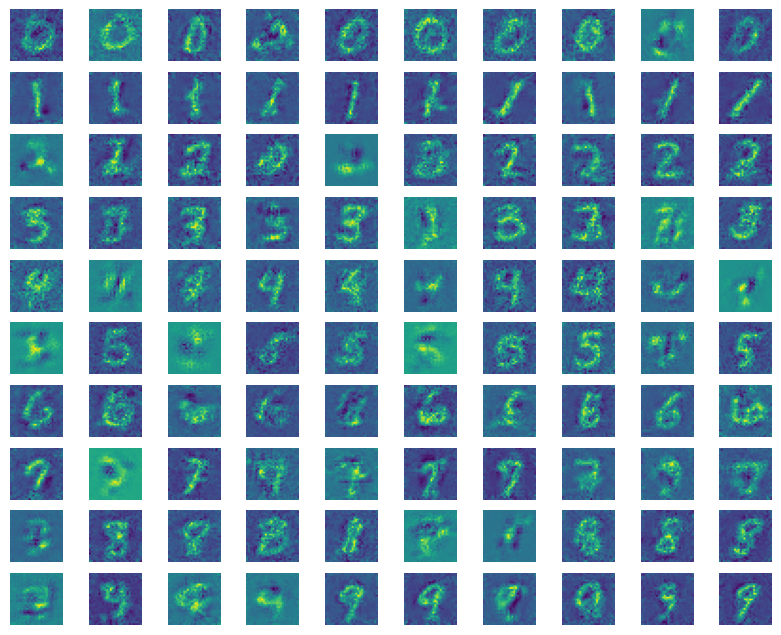

In [29]:
def print_syn_img():
    fig, axes = plt.subplots(ipc,num_classes, figsize=(10, 8))

    images_print, labels_print = copy.deepcopy(image_syn.detach()).cpu().detach().numpy(), copy.deepcopy(label_syn.detach()).cpu().detach().numpy()

    if ipc==1:
        for i in range(num_classes):
            axes[i].imshow(np.squeeze(images_print[i],axis=0))
            axes[i].axis('off')

    else:
        k=0
        for i in range(num_classes):
            for j in range(ipc):
                axes[i,j].imshow(np.squeeze(images_print[k],axis=0))
                axes[i,j].axis('off')
                k+=1
print_syn_img()